In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from matplotlib import cm

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree NeverWorld setup
#run=26 #1/8 degree NeverWorld setup
#run=28 #1/16 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [46]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=33 #1/32 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)
#av = xr.open_dataset('run%i/averages_00002002.nc' % (run), decode_times=False)  #5-day average

av=xr.open_mfdataset(['run33/averages_00001702.nc','run33/averages_00001802.nc', 'run33/averages_00001902.nc', 'run33/averages_00002002.nc', 'run33/averages_00002102.nc'],decode_times=False,combine='by_coords')
#print(av)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
lonc=fs['geolon_c']; latc=fs['geolat_c']
lonu=fs['geolon_u']; latu=fs['geolat_u']
lonv=fs['geolon_v']; latv=fs['geolat_v']
depth = fs['depth_ocean']
dxCu = fs['dxCu']; dyCv = fs['dyCv']; 
dx = (np.array(dxCu[:,:-1])+np.array(dxCu[:,1:]))*0.5
dy = (np.array(dyCv[1:,:])+np.array(dyCv[:-1,:]))*0.5

xh = fs.xh.values
yh = fs.yh.values
xq = fs.xq.values
yq = fs.yq.values

taux= forcing.taux.values[0,:,:]; taux=(taux[:,1:]+taux[:,:-1])/2.
taux.shape

(560, 240)

## Plotting the topography and zonal wind forcing:

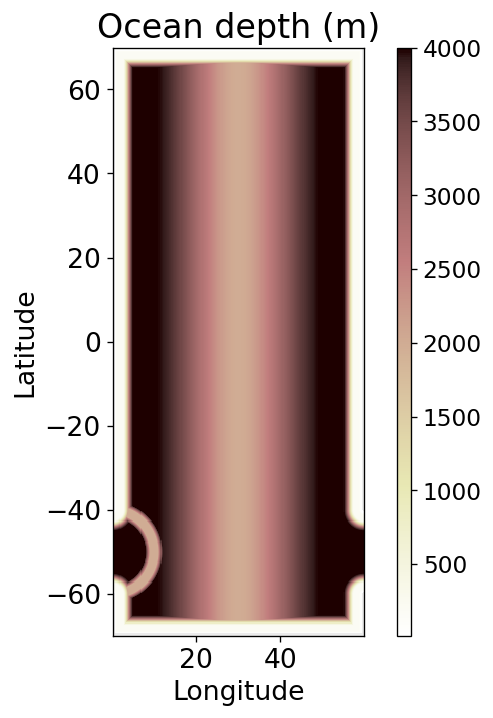

In [31]:
#Plotting ocean depth
fig = plt.figure(figsize=(4, 7), dpi= 120, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Ocean depth (m)',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,depth,cmap=cm.pink_r)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')

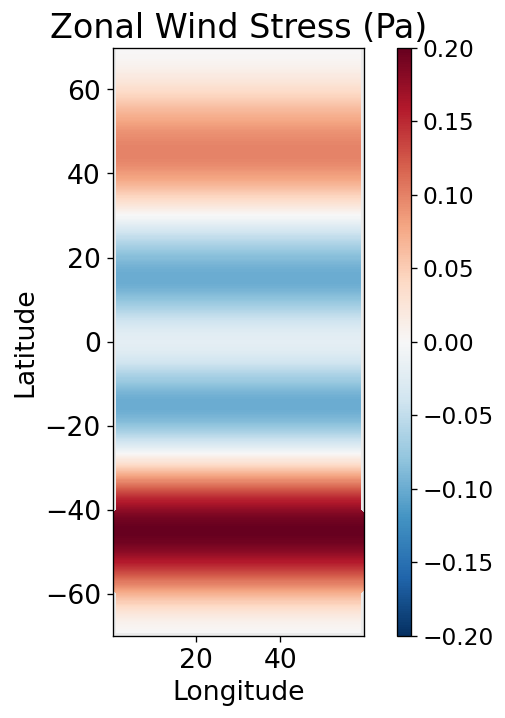

In [32]:
#Plotting zonal wind forcing (taux)
fig = plt.figure(figsize=(4, 7), dpi=120, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Zonal Wind Stress (Pa)',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,taux,cmap='RdBu_r',vmin=-0.2,vmax=0.2)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('taux.png')

### Plotting the zonal transects (density, $d\rho /dz$, u and v velocities) as 500-day averaged quantities (averaging over all 100 snapshots from the averages file):

In [7]:
#FOR ZONAL TRANSECTS AVERAGED IN TIME:
index=60 #60, 120 180 for 1/4 degree
Layer = np.array(os['Layer']);
Layermat=np.tile(Layer,[len(yh),1]); Layermat=np.moveaxis(Layermat, [0, 1], [1, 0])
Interface = np.array(os['Interface']); drho=np.diff(Interface)
drhomat=np.tile(drho,[len(yh),1]);     drhomat =np.moveaxis(drhomat, [0, 1], [1,0])


u = np.nanmean(np.array(av['u'][:,:,:,index]),axis=0);
v = np.nanmean(np.array(av['v'][:,:,:,index]),axis=0); v=(v[:,:-1]+v[:,1:])/2
h = np.nanmean(np.array(av['h'][:,:,:,index]),axis=0)
eta = np.zeros((len(Layer)+1,len(yh)));

for i in range(1,len(Layer)+1):
    eta[i,:]=np.nansum(h[0:i,:],axis=0)
#To make sure eta is correct: #print(eta[:,50,50]) #print(h[:,50,50])  

drhodz=drhomat/h 
eta.shape
u.shape

(15, 560)

In [9]:
print(eta[:,50])

[0.00000000e+00 4.38912821e-07 1.97122154e-06 1.19031238e-05
 1.70055246e-05 9.43123741e-05 4.01086872e-03 2.34763905e-01
 1.78495331e+01 3.39580444e+02 7.25698975e+02 1.19123584e+03
 1.67548047e+03 2.55352075e+03 3.28226318e+03 3.67037915e+03]


In [5]:
eta.shape

(16, 560)

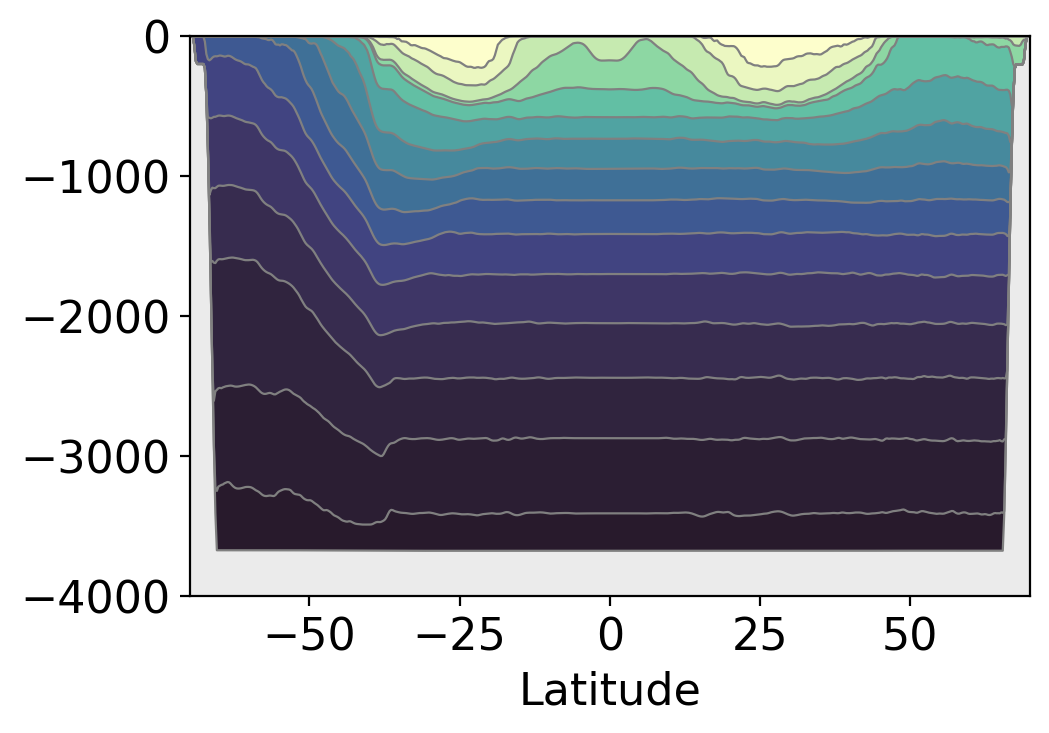

In [22]:
fig = plt.figure(figsize=(7, 4), dpi= 200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
#ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Latitude',fontsize=16)
#ax1.set_ylabel('Depth (m)',fontsize=16)
ax1.tick_params(labelsize=16); 
#ax2.set_title('kg/m$^3$',fontsize=16); ax2.tick_params(labelsize=14)
ax1.set_ylim([-4000,0])

plotted =ax1.pcolor(yh,-eta,np.array(Layermat),cmap=cmocean.cm.deep)
#cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
#cbar.ax.tick_params(labelsize=14);
for i in range(1,len(Layer)+1,1):
    line,=ax1.plot(yh,-eta[i,:],color=[.5,.5,.5],linewidth=.8) #Plot the individual layer positions, don't do this for alongshore average

plt.show()
#fig.savefig('density_transect.png')

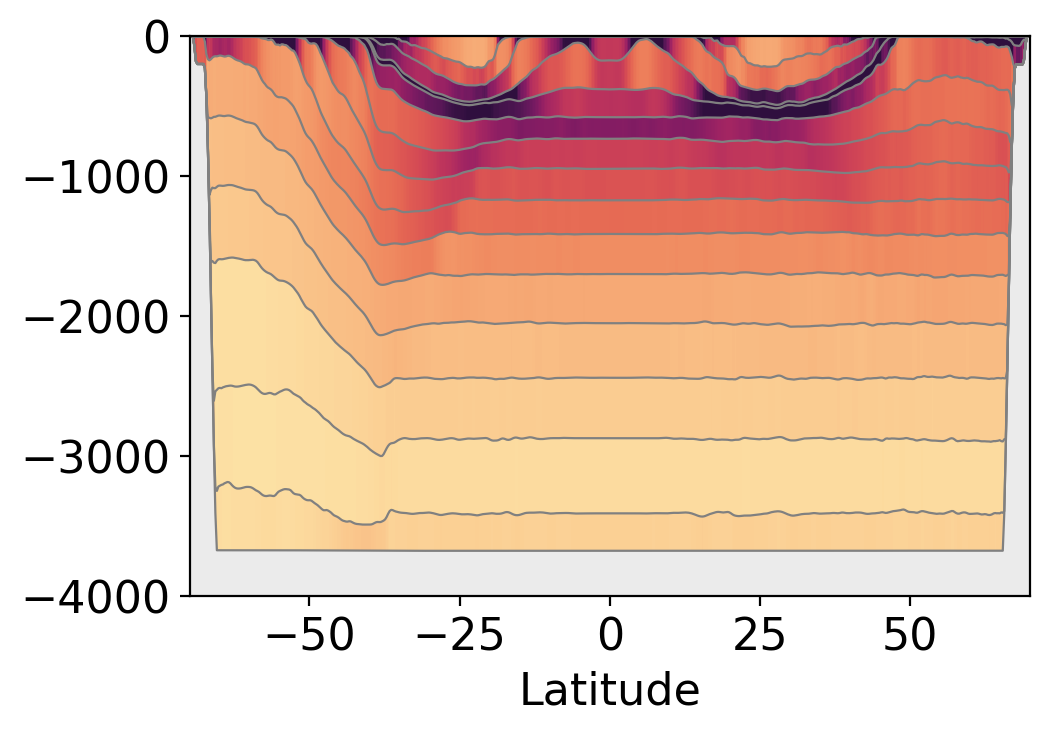

In [23]:
fig = plt.figure(figsize=(7, 4), dpi= 200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
#ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Latitude',fontsize=16)
#ax1.set_ylabel('Depth (m)',fontsize=16)
ax1.tick_params(labelsize=16); 
#ax2.set_title('kg/m$^4$',fontsize=16); ax2.tick_params(labelsize=14)
ax1.set_ylim([-4000,0])

plotted =ax1.pcolor(yh,-eta,(drhodz),cmap=cmocean.cm.matter,vmin=0,vmax=.5e-2)
#cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
#cbar.ax.tick_params(labelsize=14);
for i in range(1,len(Layer)+1,1):
    line,=ax1.plot(yh,-eta[i,:],color=[.5,.5,.5],linewidth=.8) #Plot the individual layer positions, don't do this for alongshore average

plt.show()
#fig.savefig('drhodz_transect.png')

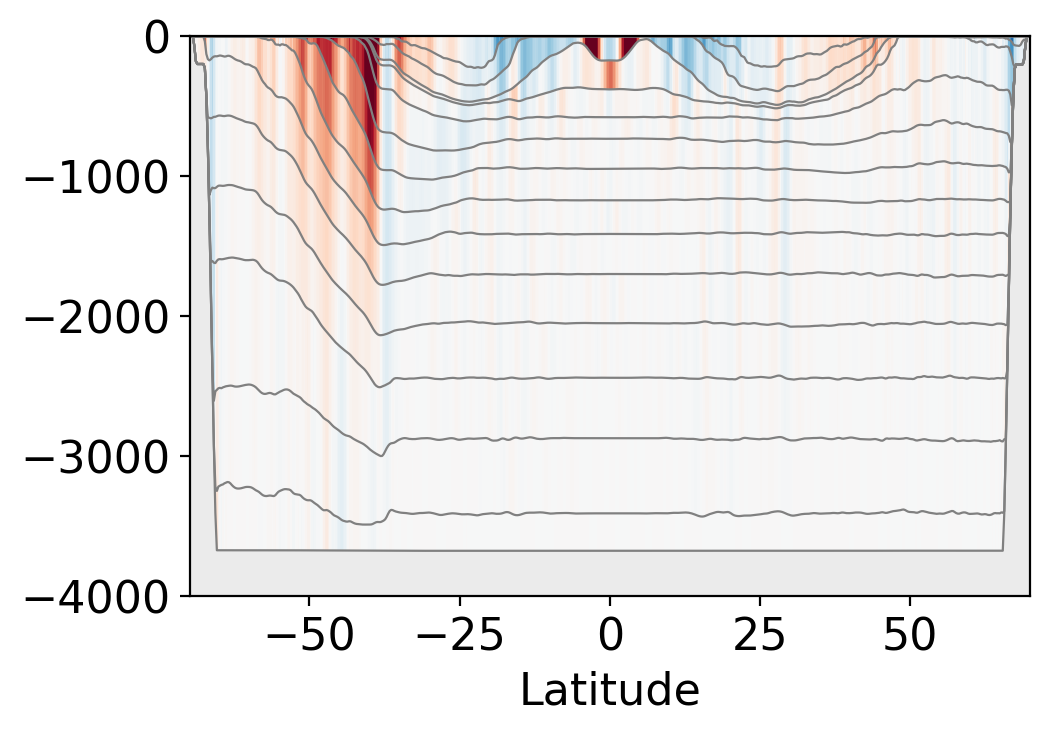

In [24]:
fig = plt.figure(figsize=(7, 4), dpi= 200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
#ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Latitude',fontsize=16)
#ax1.set_ylabel('Depth (m)',fontsize=16)
ax1.tick_params(labelsize=16); 
#ax2.set_title('m/s',fontsize=16); ax2.tick_params(labelsize=14)
ax1.set_ylim([-4000,0])

plotted =ax1.pcolor(yh,-eta,u,cmap='RdBu_r',vmin=-0.25,vmax=0.25)
#cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
#cbar.ax.tick_params(labelsize=14);
for i in range(1,len(Layer)+1,1):
    line,=ax1.plot(yh,-eta[i,:],color=[.5,.5,.5],linewidth=.8) #Plot the individual layer positions, don't do this for alongshore average

plt.show()
#fig.savefig('u_velocity_transect.png')

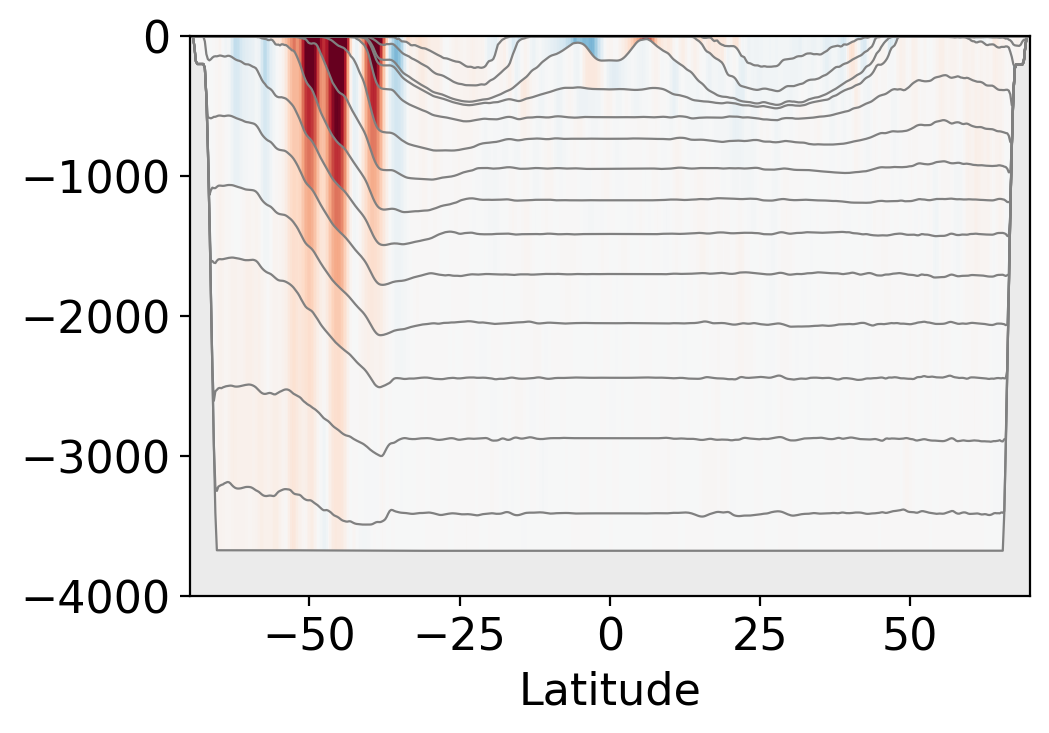

In [25]:
fig = plt.figure(figsize=(7, 4), dpi= 200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
#ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Latitude',fontsize=16)
#ax1.set_ylabel('Depth (m)',fontsize=16)
ax1.tick_params(labelsize=16); 
#ax2.set_title('m/s',fontsize=16); ax2.tick_params(labelsize=14)
ax1.set_ylim([-4000,0])

plotted =ax1.pcolor(yh,-eta,v,cmap='RdBu_r',vmin=-0.25,vmax=0.25)
#cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
#cbar.ax.tick_params(labelsize=14);
for i in range(1,len(Layer)+1,1):
    line,=ax1.plot(yh,-eta[i,:],color=[.5,.5,.5],linewidth=.8) #Plot the individual layer positions, don't do this for alongshore average

plt.show()
#fig.savefig('v_velocity_transect.png')

In [48]:
#Alongshore averages
Layer = np.array(os['Layer']);
Layermat=np.tile(Layer,[len(yh),1]); Layermat=np.moveaxis(Layermat, [0, 1], [1, 0])
Interface = np.array(os['Interface']); drho=np.diff(Interface)
drhomat=np.tile(drho,[len(yh),1]);     drhomat =np.moveaxis(drhomat, [0, 1], [1,0])


u = np.nanmean(np.nanmean(np.array(av['u'][:,:,:,:]),axis=0),axis=2);
v = np.nanmean(np.nanmean(np.array(av['v'][:,:,:,:]),axis=0),axis=2); v=(v[:,:-1]+v[:,1:])/2
h = np.nanmean(np.nanmean(np.array(av['h'][:,:,:,:]),axis=0),axis=2);
eta = np.zeros((len(Layer)+1,len(yh)));

for i in range(1,len(Layer)+1):
    eta[i,:]=np.nansum(h[0:i,:],axis=0)
#To make sure eta is correct: #print(eta[:,50,50]) #print(h[:,50,50])  

drhodz=drhomat/h 
eta.shape
u.shape



(15, 4480)

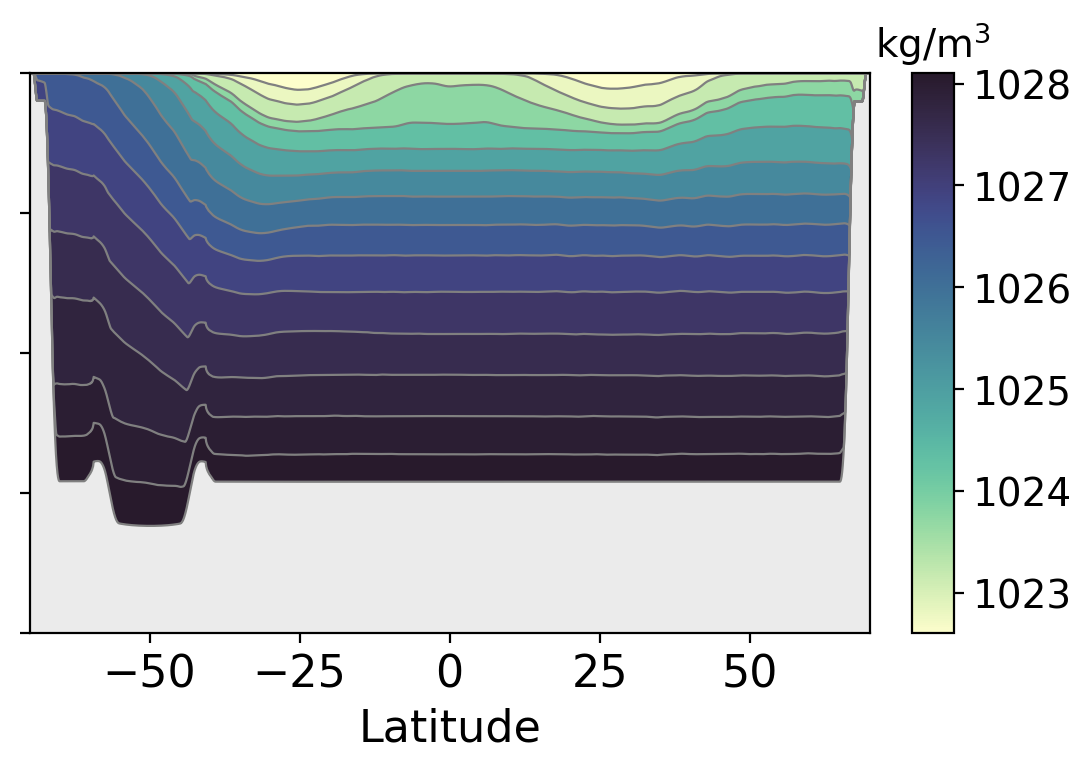

In [50]:
fig = plt.figure(figsize=(7, 4), dpi= 200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Latitude',fontsize=16)
ax1.set_yticklabels('')
#ax1.set_ylabel('Depth (m)',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.set_title('kg/m$^3$',fontsize=14); ax2.tick_params(labelsize=14)
ax1.set_ylim([-4000,0])

plotted =ax1.pcolor(yh,-eta,np.array(Layermat),cmap=cmocean.cm.deep)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
for i in range(1,len(Layer)+1,1):
    line,=ax1.plot(yh,-eta[i,:],color=[0.5,0.5,0.5],linewidth=.8) #Plot the individual layer positions, don't do this for alongshore average

plt.show()
#fig.savefig('density_transect.png')

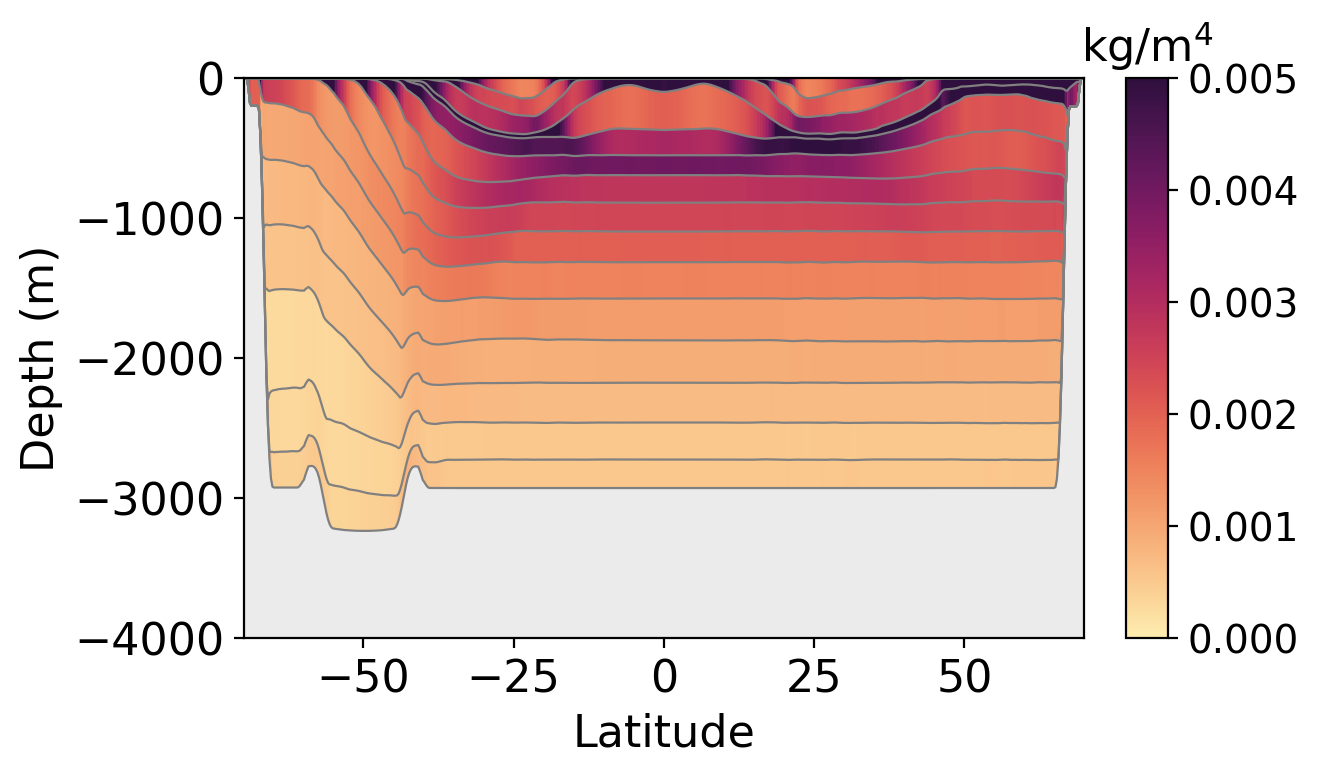

In [23]:
fig = plt.figure(figsize=(7, 4), dpi= 200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Latitude',fontsize=16)
ax1.set_ylabel('Depth (m)',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.set_title('kg/m$^4$',fontsize=16); ax2.tick_params(labelsize=14)
ax1.set_ylim([-4000,0])

plotted =ax1.pcolor(yh,-eta,(drhodz),cmap=cmocean.cm.matter,vmin=0,vmax=.5e-2)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
for i in range(1,len(Layer)+1,1):
    line,=ax1.plot(yh,-eta[i,:],color=[.5,.5,.5],linewidth=.8) #Plot the individual layer positions, don't do this for alongshore average

plt.show()
#fig.savefig('drhodz_transect.png')

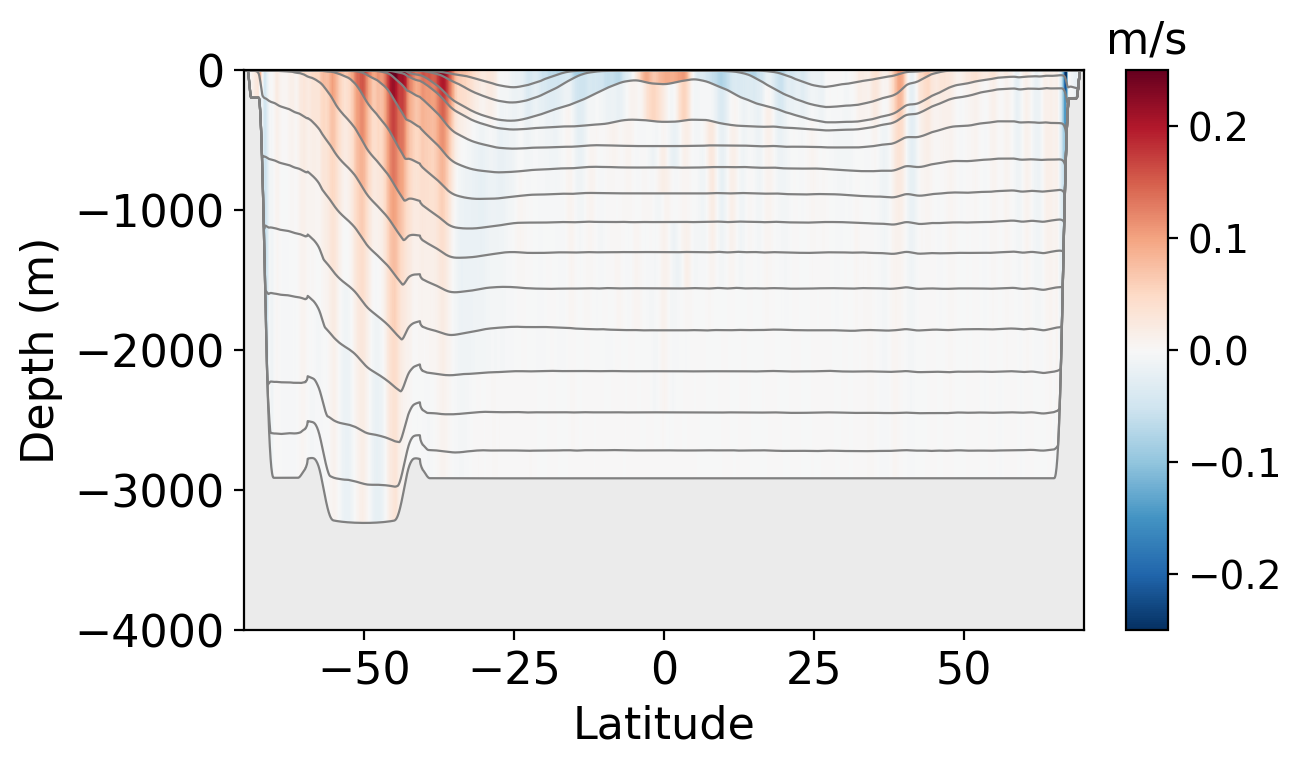

In [53]:
fig = plt.figure(figsize=(7, 4), dpi= 200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Latitude',fontsize=16)
ax1.set_ylabel('Depth (m)',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.set_title('m/s',fontsize=16); ax2.tick_params(labelsize=14)
ax1.set_ylim([-4000,0])

plotted =ax1.pcolor(yh,-eta,u,cmap='RdBu_r',vmin=-0.25,vmax=0.25)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
for i in range(1,len(Layer)+1,1):
    line,=ax1.plot(yh,-eta[i,:],color=[.5,.5,.5],linewidth=.8) #Plot the individual layer positions, don't do this for alongshore average

plt.show()
#fig.savefig('u_velocity_transect.png')

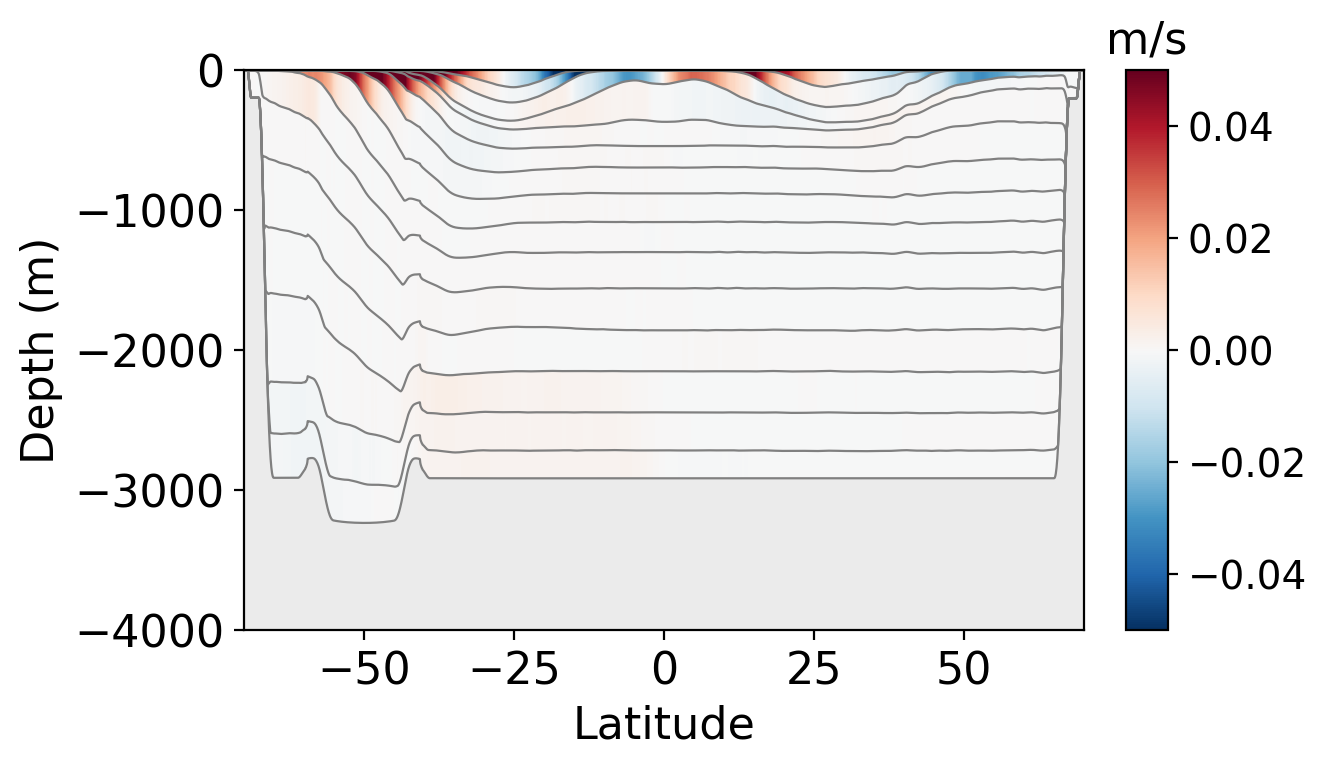

In [55]:
fig = plt.figure(figsize=(7, 4), dpi= 200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Latitude',fontsize=16)
ax1.set_ylabel('Depth (m)',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.set_title('m/s',fontsize=16); ax2.tick_params(labelsize=14)
ax1.set_ylim([-4000,0])

plotted =ax1.pcolor(yh,-eta,v,cmap='RdBu_r',vmin=-0.05,vmax=0.05)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
for i in range(1,len(Layer)+1,1):
    line,=ax1.plot(yh,-eta[i,:],color=[.5,.5,.5],linewidth=.8) #Plot the individual layer positions, don't do this for alongshore average

plt.show()

In [17]:
#2000 day averages

%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20 #1/4 degree NeverWorld setup
#run=26 #1/8 degree NeverWorld setup
run=28 #1/16 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

av     = xr.open_mfdataset({'run%i/averages_00030002.nc' % (run),'run%i/averages_00030502.nc' % (run),'run%i/averages_00031002.nc' % (run),'run%i/averages_00031502.nc' % (run)}, decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [18]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
lonc=fs['geolon_c']; latc=fs['geolat_c']
lonu=fs['geolon_u']; latu=fs['geolat_u']
lonv=fs['geolon_v']; latv=fs['geolat_v']
depth = fs['depth_ocean']
dxCu = fs['dxCu']; dyCv = fs['dyCv']; 
dx = (np.array(dxCu[:,:-1])+np.array(dxCu[:,1:]))*0.5
dy = (np.array(dyCv[1:,:])+np.array(dyCv[:-1,:]))*0.5

xh = fs.xh.values
yh = fs.yh.values
xq = fs.xq.values
yq = fs.yq.values

taux= forcing.taux.values[0,:,:]; taux=(taux[:,1:]+taux[:,:-1])/2.
taux.shape

(2240, 960)

In [23]:
#FOR ZONAL TRANSECTS AVERAGED IN TIME:
index=720 #60, 120 180 for 1/4 degree
Layer = np.array(os['Layer']);
Layermat=np.tile(Layer,[len(yh),1]); Layermat=np.moveaxis(Layermat, [0, 1], [1, 0])
Interface = np.array(os['Interface']); drho=np.diff(Interface)
drhomat=np.tile(drho,[len(yh),1]);     drhomat =np.moveaxis(drhomat, [0, 1], [1,0])


u = np.nanmean(np.array(av['u'][:,:,:,index]),axis=0);
v = np.nanmean(np.array(av['v'][:,:,:,index]),axis=0); v=(v[:,:-1]+v[:,1:])/2
h = np.nanmean(np.array(av['h'][:,:,:,index]),axis=0)
eta = np.zeros((len(Layer)+1,len(yh)));

for i in range(1,len(Layer)+1):
    eta[i,:]=np.nansum(h[0:i,:],axis=0)
#To make sure eta is correct: #print(eta[:,50,50]) #print(h[:,50,50])  

drhodz=drhomat/h 
eta.shape
u.shape

(15, 2240)

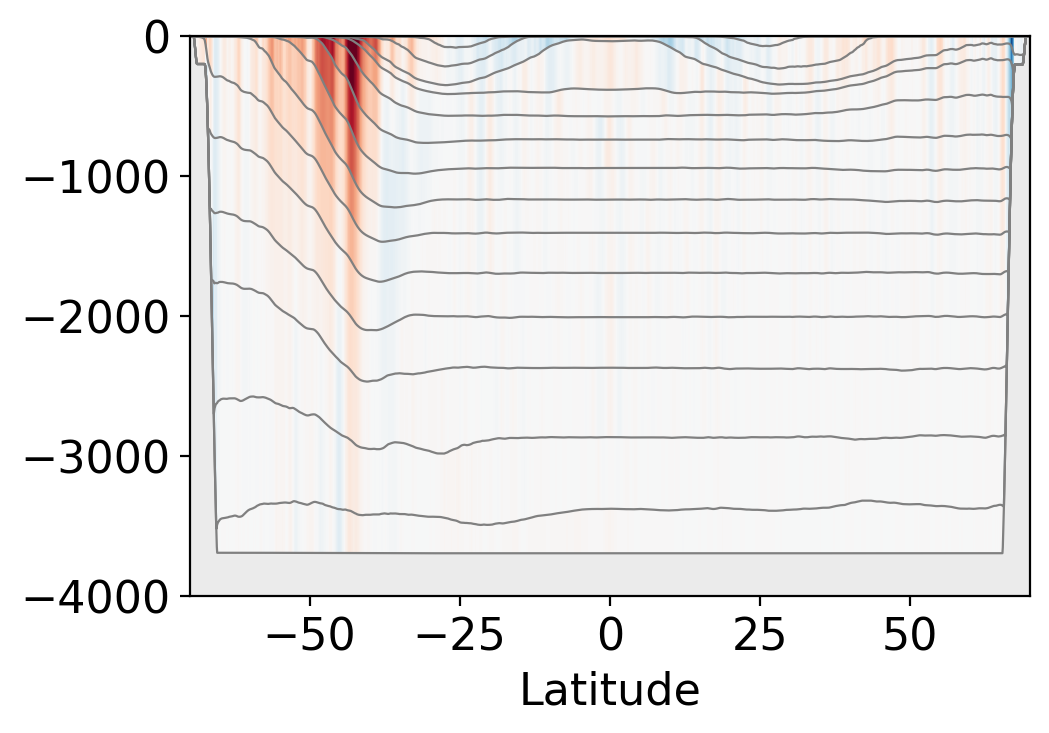

In [24]:
fig = plt.figure(figsize=(7, 4), dpi= 200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
#ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Latitude',fontsize=16)
#ax1.set_ylabel('Depth (m)',fontsize=16)
ax1.tick_params(labelsize=16); 
#ax2.set_title('m/s',fontsize=16); ax2.tick_params(labelsize=14)
ax1.set_ylim([-4000,0])

plotted =ax1.pcolor(yh,-eta,u,cmap='RdBu_r',vmin=-0.25,vmax=0.25)
#cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
#cbar.ax.tick_params(labelsize=14);
for i in range(1,len(Layer)+1,1):
    line,=ax1.plot(yh,-eta[i,:],color=[.5,.5,.5],linewidth=.8) #Plot the individual layer positions, don't do this for alongshore average

plt.show()
#fig.savefig('u_velocity_transect.png')